The model can account for spacing, but interestingly only with a power function. Two basic findings:
* smaller lag between study sessions leads to better immediate memory, but worse delayed memory
* the optimal lag between study sessions increases as the delay period of the test increases

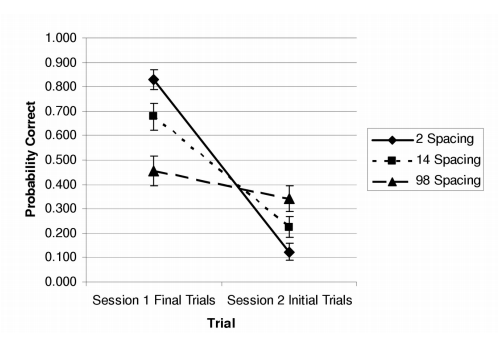
*Figure 1. Pavlik and Anderson (2005) data, showing the effect of study lag on immediate and delayed testing*

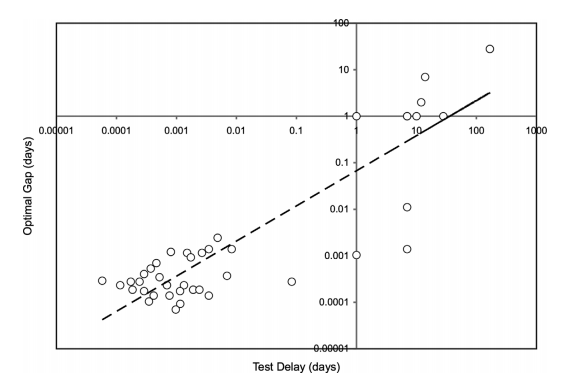
*Figure 2. Cepeda et al (2008) data, showing that the optimal study lag increases as the test delay increases*

The model below has a learning function with power decay of inidividual incrememnets of the following form: 

$$\sum{s_n\times(1+t_n)^{-d}}$$

where $s_n$ is the size of increment $n$, $t_n$ is time (in seconds) since the increment, and $d$ is the decay parameter

The model generates predicted base-level activation for different values of spacing/gap/lag between study repetitions and lag between last repetition and testing (test delay). The plot shows for each combination of study gap and test delay the scaled base-level activation values, where 1 is the highest for this Test day, and 0 is the lowest. The hotter the color, the greater the base-level activation for this pair of study-test lags. The dotted line shows the optimal study gap predicted by the model for each test delay.

`geom_smooth()` using method = 'loess'


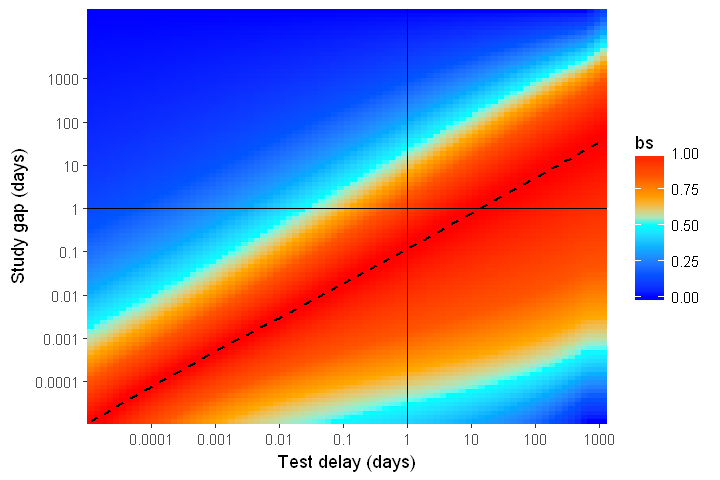

In [177]:
library(tidyverse)
library(colorRamps)
options(repr.plot.width=6, repr.plot.height=4)

base <- function(t, currentTime, p=0.5, d=0.5) {
  # the first increment is just p
  B=0
  deltaB = p
  # for every increment after that, check if it has occured yet (t[i] <= currentTime)
  # if it has occured, calculate B at time t[i], which is multiplying each increment 
  # by the forgetting function of how much time has passed since then
  # finally, calculate the current increment size based on B
  for (i in 2:length(t)) {
    if (t[i] <= currentTime) {
      B = sum(deltaB * (1 + t[i] - t[1:(i-1)])^(-d))
      deltaB[i] = p * (1-B)
    }
  }
  # set the time to 0 if the event hasn't occured yet (-1, because of the 1+time in the eq below
  # then calculate B at the current time)
  time = ifelse(currentTime - t[1:length(deltaB)] < 0, -1, currentTime - t[1:length(deltaB)])
  B = sum(deltaB * (1 + time)^(-d))
  return(B)
}

data <- expand.grid(lag=seq(0,8,0.1), spacing=seq(0,9.5,0.1))
data$b <- apply(data, 1, function(x) base(c(0, 10**x[2]),10**x[1]+10**x[2], p=0.65, d=0.2))


tmp <- data %>% 
  group_by(lag) %>% 
  mutate(bs = (b-min(b))/max(b-min(b))) %>% 
  mutate(maxb = bs == 1) %>%
  ungroup()  %>% 
  mutate(lag = 10**lag/86400, 
         spacing = 10**spacing/86400)

options(scipen=10000)
breaks = c(0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,1000)
tmp  %>% 
  ggplot(aes(lag, spacing, fill=bs)) +
  geom_tile() +
  geom_smooth(data=tmp %>% filter(maxb==TRUE), aes(x=lag, y=spacing), linetype='dashed', color='black', size=0.7) +
  scale_fill_gradientn(colours=blue2red(7)) +
  scale_x_log10(name='Test delay (days)', breaks=breaks, labels = breaks, expand = c(0, 0)) +
  scale_y_log10(name='Study gap (days)', breaks=breaks, labels=breaks, expand = c(0, 0)) +
  geom_hline(yintercept = 1) +
  geom_vline(xintercept = 1) +
  theme(panel.grid = element_blank(), panel.border = element_blank())  
    

In contrast, when we use an exponential forgetting function of the following form:

$$\sum{s_n\times e^{-d t}}$$

We don't see either an effect of spacing or variability of the optimal gap (in fact, base-level activation goes to 0 after very long test delays, so it is not possible to compute optimal gap - grey regions of plot):

`geom_smooth()` using method = 'loess'


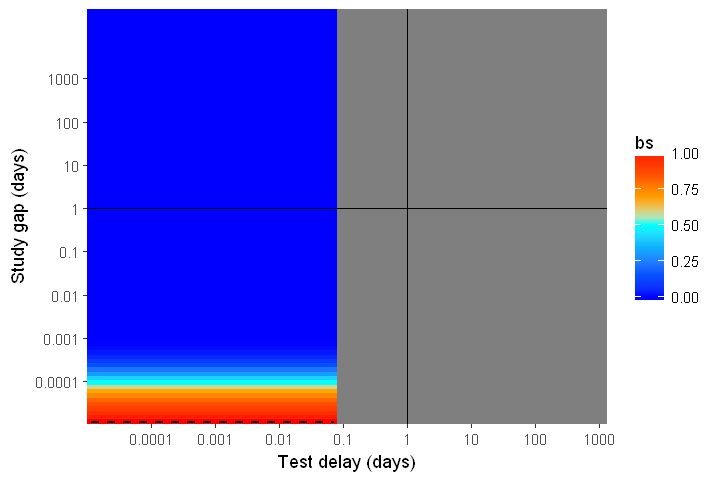

In [158]:
base_exp <- function(t, currentTime, p=0.5, d=0.1) {
  B=0
  deltaB = p
  for (i in 2:length(t)) {
    if (t[i] <= currentTime) {
      B = sum(deltaB * exp(-d*(t[i] - t[1:(i-1)])))
      deltaB[i] = p * (1-B)
    }
  }
  time = ifelse(currentTime - t[1:length(deltaB)] < 0, 0, currentTime - t[1:length(deltaB)])
  B = sum(deltaB * exp(-d*time))
  return(B)
}

data <- expand.grid(lag=seq(0,8,0.1), spacing=seq(0,9.5,0.1))
data$b <- apply(data, 1, function(x) base_exp(c(0, 10**x[2]),10**x[1]+10**x[2], p=0.65, d=0.1))


tmp <- data %>% 
  group_by(lag) %>% 
  mutate(bs = (b-min(b))/max(b-min(b))) %>% 
  mutate(maxb = bs == 1) %>%
  ungroup()  %>% 
  mutate(lag = 10**lag/86400, 
         spacing = 10**spacing/86400)

options(scipen=10000)
breaks = c(0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,1000)
tmp  %>% 
  ggplot(aes(lag, spacing, fill=bs)) +
  geom_tile() +
  geom_smooth(data=tmp %>% filter(maxb==TRUE), aes(x=lag, y=spacing), linetype='dashed', color='black', size=0.7) +
  scale_fill_gradientn(colours=blue2red(7)) +
  scale_x_log10(name='Test delay (days)', breaks=breaks, labels = breaks, expand = c(0, 0)) +
  scale_y_log10(name='Study gap (days)', breaks=breaks, labels=breaks, expand = c(0, 0)) +
  geom_hline(yintercept = 1) +
  geom_vline(xintercept = 1) +
  theme(panel.grid = element_blank(), panel.border = element_blank())  

`geom_smooth()` using method = 'loess'


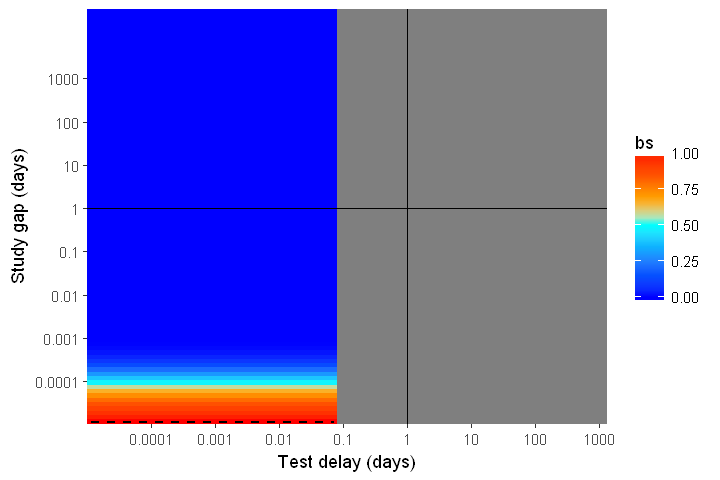

In [169]:
base_exp2 <- function(t, currentTime, p=0.5, d=0.1) {
  B=0
  deltaB = p
  for (i in 2:length(t)) {
    if (t[i] <= currentTime) {
      B = sum(deltaB * (d**(t[i] - t[1:(i-1)])))
      deltaB[i] = p * (1-B)
    }
  }
  time = ifelse(currentTime - t[1:length(deltaB)] < 0, 0, currentTime - t[1:length(deltaB)])
  B = sum(deltaB * (d**time))
  return(B)
}

data <- expand.grid(lag=seq(0,8,0.1), spacing=seq(0,9.5,0.1))
data$b <- apply(data, 1, function(x) base_exp2(c(0, 10**x[2]),10**x[1]+10**x[2], p=0.65, d=0.9))


tmp <- data %>% 
  group_by(lag) %>% 
  mutate(bs = (b-min(b))/max(b-min(b))) %>% 
  mutate(maxb = bs == 1) %>%
  ungroup()  %>% 
  mutate(lag = 10**lag/86400, 
         spacing = 10**spacing/86400)

options(scipen=10000)
breaks = c(0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,1000)
tmp  %>% 
  ggplot(aes(lag, spacing, fill=bs)) +
  geom_tile() +
  geom_smooth(data=tmp %>% filter(maxb==TRUE), aes(x=lag, y=spacing), linetype='dashed', color='black', size=0.7) +
  scale_fill_gradientn(colours=blue2red(7)) +
  scale_x_log10(name='Test delay (days)', breaks=breaks, labels = breaks, expand = c(0, 0)) +
  scale_y_log10(name='Study gap (days)', breaks=breaks, labels=breaks, expand = c(0, 0)) +
  geom_hline(yintercept = 1) +
  geom_vline(xintercept = 1) +
  theme(panel.grid = element_blank(), panel.border = element_blank())  